# Imports

In [16]:
import os
import logging
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from kaggle.api.kaggle_api_extended import KaggleApi

from utils import DepressionDataProcessor

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, recall_score, f1_score


from catboost import CatBoostClassifier

plt.style.use('ggplot')
%matplotlib inline

ISKAGGLE = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "") != ""

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


# Data Loading

In [17]:

processor = DepressionDataProcessor("anthonytherrien/depression-dataset")
processor.download_and_extract()

2025-02-21 09:52:00,031 - INFO - Downloading dataset using Kaggle API...


datasets\depression-dataset
Dataset URL: https://www.kaggle.com/datasets/anthonytherrien/depression-dataset


2025-02-21 09:52:02,529 - INFO - Dataset downloaded and extracted successfully.


In [18]:
raw_df = processor.load_data("depression_data.csv")

In [19]:

processed_df = processor.preprocess(raw_df)
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   Age                              413768 non-null  int64   
 1   Marital Status                   413768 non-null  category
 2   Education Level                  413768 non-null  category
 3   Number of Children               413768 non-null  category
 4   Smoking Status                   413768 non-null  category
 5   Physical Activity Level          413768 non-null  category
 6   Employment Status                413768 non-null  category
 7   Income                           413768 non-null  float64 
 8   Alcohol Consumption              413768 non-null  category
 9   Dietary Habits                   413768 non-null  category
 10  Sleep Patterns                   413768 non-null  category
 11  History of Mental Illness        413768 non-null  ca

In [20]:
for feature in processed_df.select_dtypes(include='category').columns:
        print(f'{feature}: {processed_df[feature].unique()}')

Marital Status: ['Married', 'Widowed', 'Divorced', 'Single']
Categories (4, object): ['Divorced', 'Married', 'Single', 'Widowed']
Education Level: ['Bachelor's Degree', 'High School', 'Master's Degree', 'Associate Degree', 'PhD']
Categories (5, object): ['Associate Degree', 'Bachelor's Degree', 'High School', 'Master's Degree', 'PhD']
Number of Children: ['2', '1', '3', '0', '4']
Categories (5, object): ['0', '1', '2', '3', '4']
Smoking Status: ['Non-smoker', 'Former', 'Current']
Categories (3, object): ['Current', 'Former', 'Non-smoker']
Physical Activity Level: ['Active', 'Sedentary', 'Moderate']
Categories (3, object): ['Active', 'Moderate', 'Sedentary']
Employment Status: ['Unemployed', 'Employed']
Categories (2, object): ['Employed', 'Unemployed']
Alcohol Consumption: ['Moderate', 'High', 'Low']
Categories (3, object): ['High', 'Low', 'Moderate']
Dietary Habits: ['Moderate', 'Unhealthy', 'Healthy']
Categories (3, object): ['Healthy', 'Moderate', 'Unhealthy']
Sleep Patterns: ['Fair

In [21]:
features = [
    'Income Bucket Employment Status',
    'Marital Status', 
    'Number of Children', 
    'Smoking Status',
    'Physical Activity Level', 
    'Alcohol Consumption',
    'Dietary Habits', 
    'Sleep Patterns',
    'History of Substance Abuse', 
    'Family History of Depression',
    'Chronic Medical Conditions', 
    'Age Bucket', 
    'Attended University',
    'Education Level',
]
target = 'History of Mental Illness'

X = processed_df[features]
y = processed_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Model Fitting

- I use stratify to ensure test and train have the same imbalance of classes
- I use sample_pos_weight to deal with the imbalanced target and help with the F1 score
---

- We can increase the sample weights to push the model toward more false positives so that we dont miss diagnosing depression and can alert people at risk

In [22]:
accuracy = []
recall = []
roc_auc = []
precision = []
f1_scores = []
model_names = []

categorical_features_indices = np.where(X.dtypes == 'category')[0]

class_weights = y_train.value_counts(normalize=True).to_dict()
class_weights = class_weights[0] / class_weights[1]

with open('catboost_best_params.json', 'r') as f:
    loaded_best_params = json.load(f)

catboost_base = CatBoostClassifier(scale_pos_weight=class_weights,**loaded_best_params)
catboost_base.fit(X_train, y_train, cat_features=categorical_features_indices)

# Model Evaluation

In [23]:
y_pred = catboost_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred, zero_division=0), 4))
f1_scores.append(round(f1_score(y_test, y_pred), 4))

model_names.append('Catboost_normal_weight')

result_df1 = pd.DataFrame({'Accuracy': accuracy, 'Recall': recall, 'Roc_Auc': roc_auc, 'Precision': precision, 'F1 Score': f1_scores}, index=model_names)
result_df1

,Accuracy,Recall,Roc_Auc,Precision,F1 Score
Catboost_normal_weight,0.5966,0.5147,0.5736,0.3796,0.437


                        Accuracy  Recall  Roc_Auc  Precision  F1 Score
Catboost_normal_weight    0.5966  0.5147   0.5736     0.3796     0.437


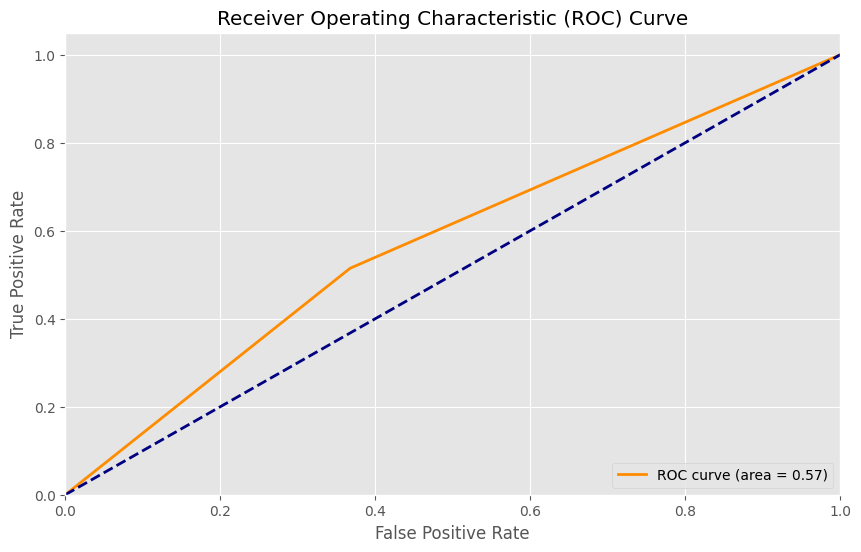

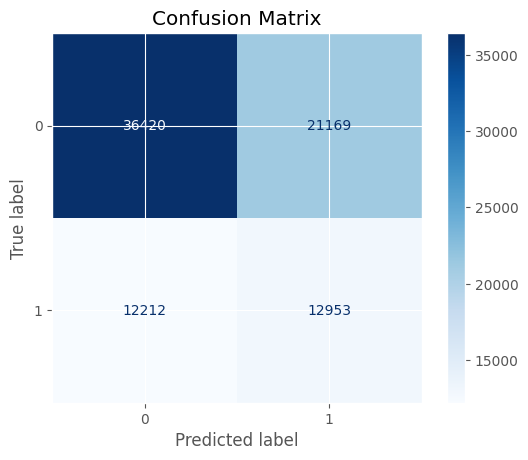

In [24]:
print(result_df1)

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

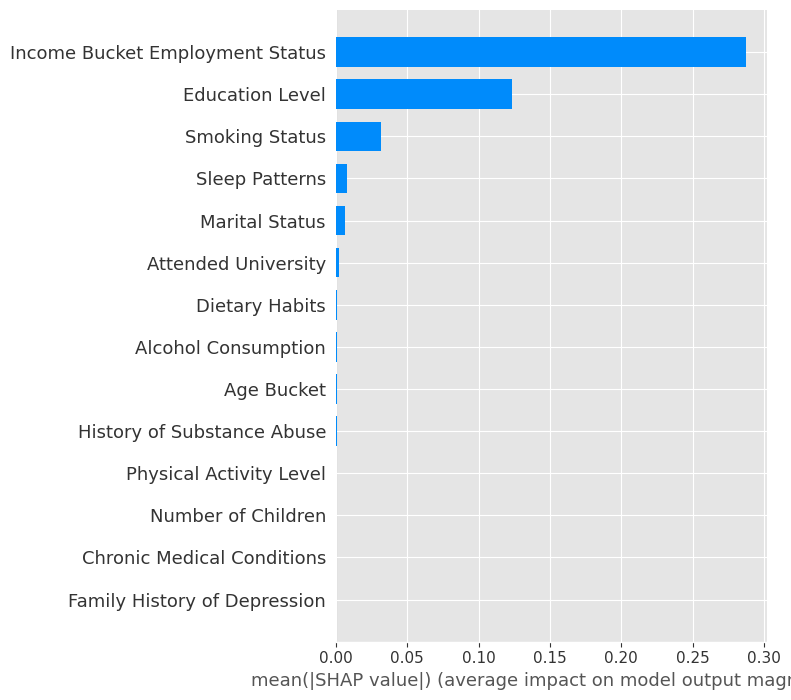

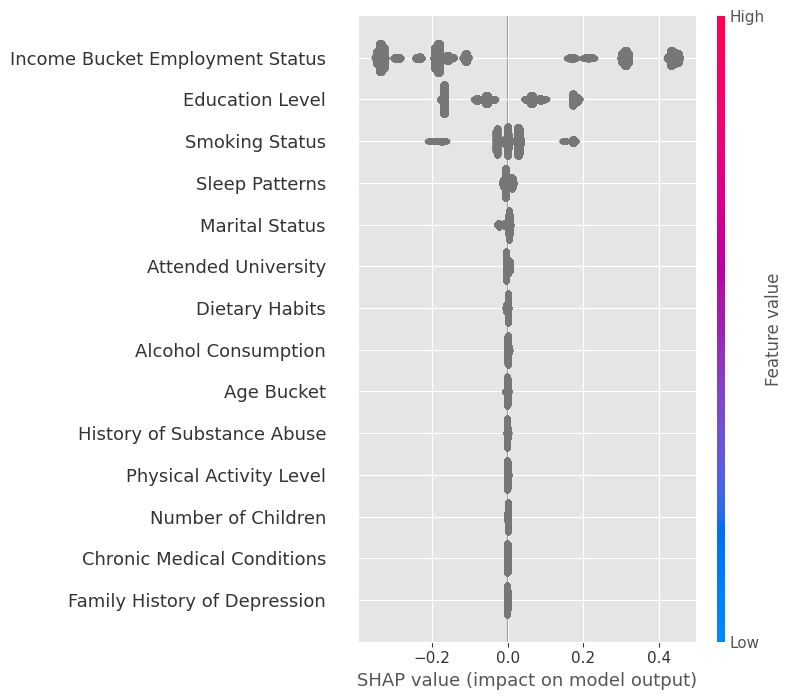

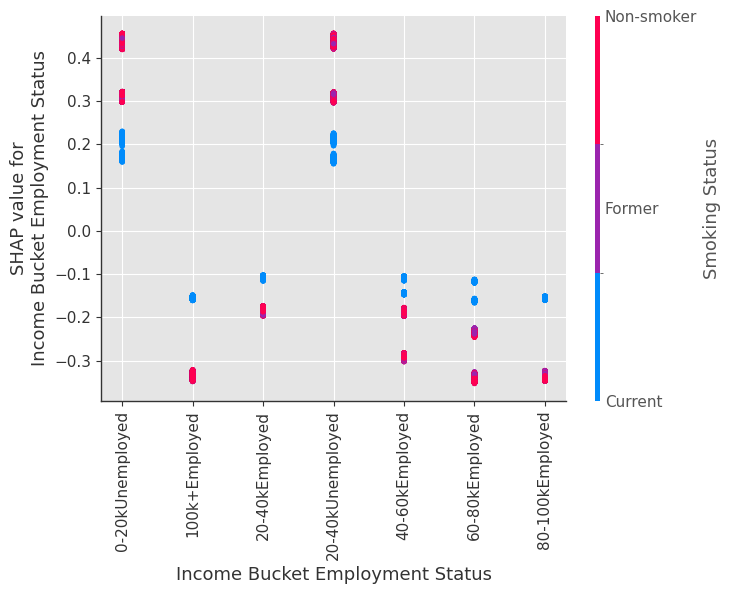

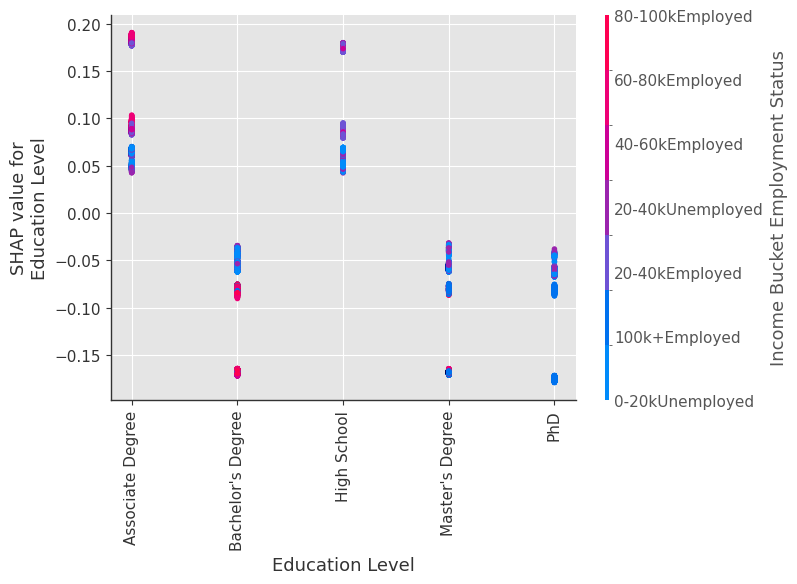

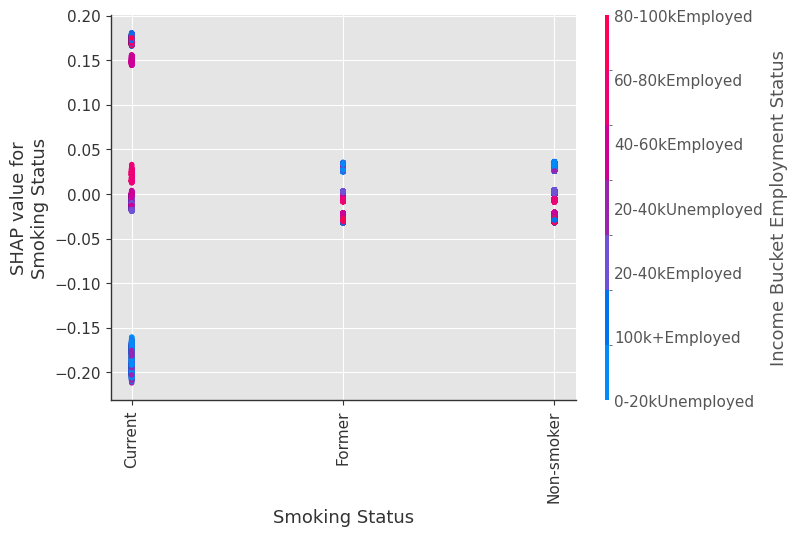

In [25]:
explainer = shap.TreeExplainer(catboost_base)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)

shap.dependence_plot("Income Bucket Employment Status", shap_values, X_test)
shap.dependence_plot("Education Level", shap_values, X_test)
shap.dependence_plot("Smoking Status", shap_values, X_test)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

## Shifting the model to create more false positive so we dont miss cases of depression

In [26]:
categorical_features_indices = np.where(X.dtypes == 'category')[0]

# Calculate scale_pos_weight
sample_weights = 3

loaded_best_params.update({'scale_pos_weight': sample_weights})

catboost_weight_3 = CatBoostClassifier(**loaded_best_params)
catboost_weight_3.fit(X_train, y_train, cat_features=categorical_features_indices)

# Model Evaluation
- Here we sacrifice accuracy for better recall

In [27]:
accuracy = []
recall = []
roc_auc = []
precision = []
f1_scores = []
model_names = []

y_pred = catboost_weight_3.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))
f1_scores.append(round(f1_score(y_test, y_pred), 4))

model_names.append('Catboost_Weight_3')

result_df1 = pd.DataFrame({'Accuracy': accuracy, 'Recall': recall, 'Roc_Auc': roc_auc, 'Precision': precision, 'F1 Score': f1_scores}, index=model_names)
result_df1

,Accuracy,Recall,Roc_Auc,Precision,F1 Score
Catboost_Weight_3,0.4776,0.8092,0.571,0.3464,0.4851


                   Accuracy  Recall  Roc_Auc  Precision  F1 Score
Catboost_Weight_3    0.4776  0.8092    0.571     0.3464    0.4851


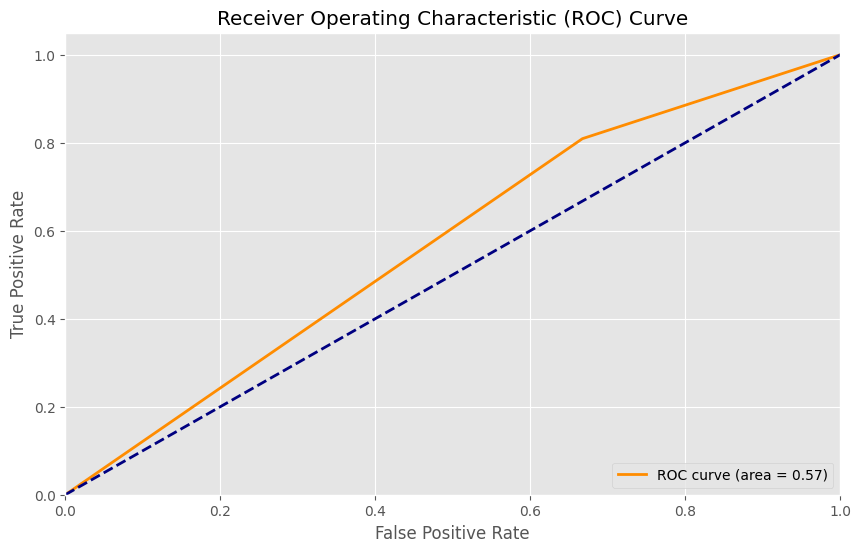

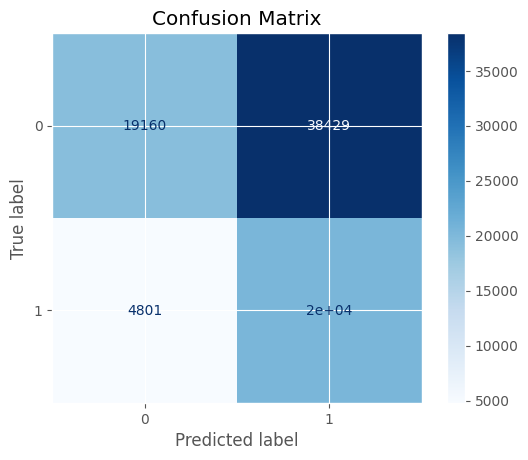

In [28]:
print(result_df1)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

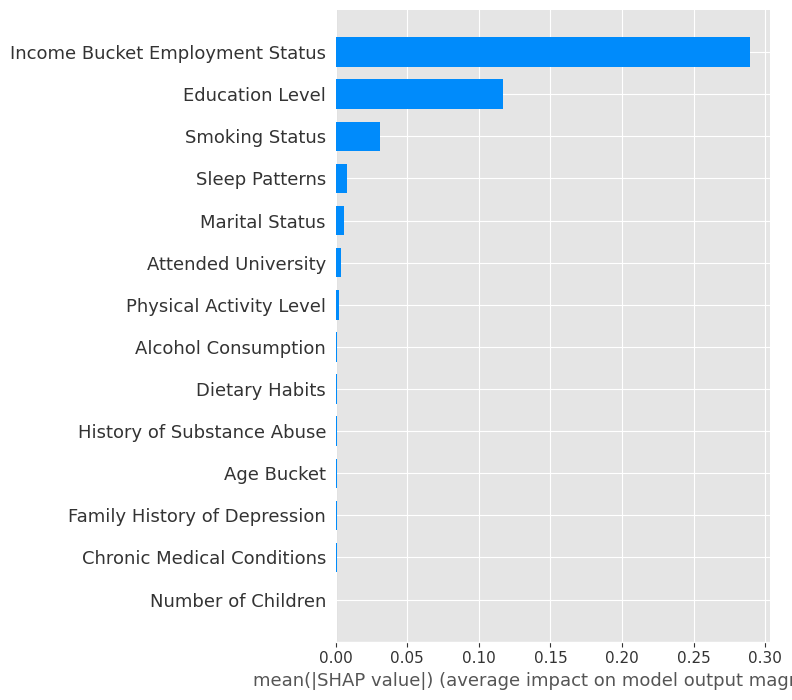

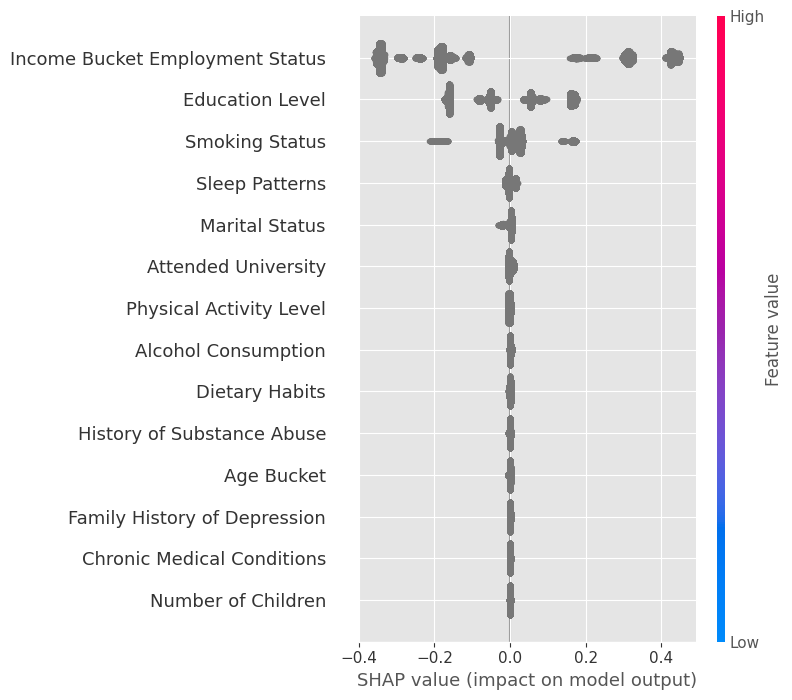

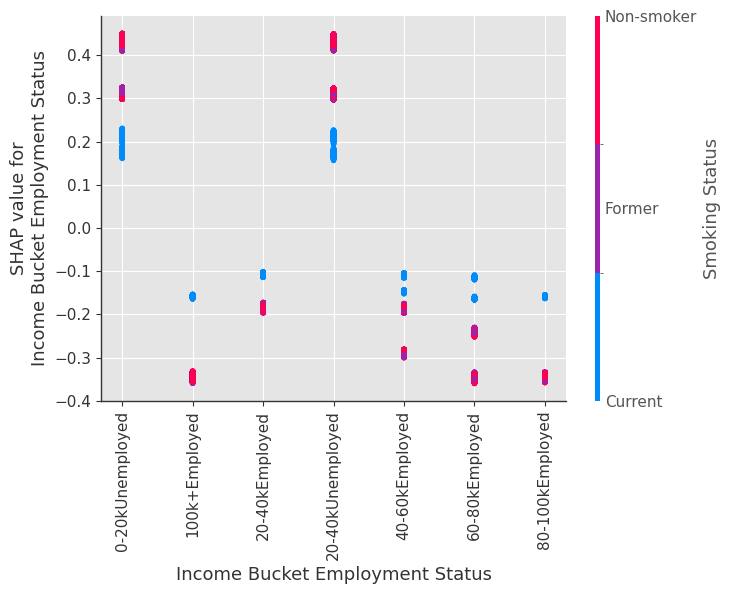

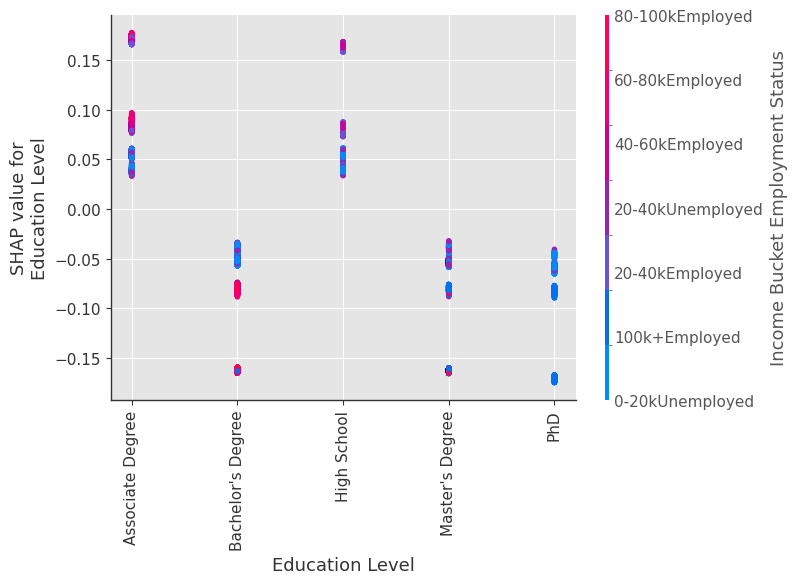

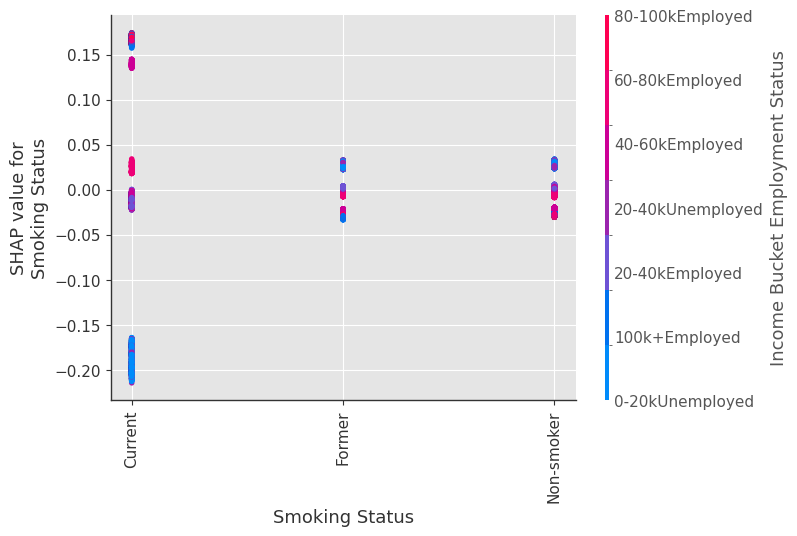

In [29]:
explainer = shap.TreeExplainer(catboost_weight_3)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)

shap.dependence_plot("Income Bucket Employment Status", shap_values, X_test)
shap.dependence_plot("Education Level", shap_values, X_test)
shap.dependence_plot("Smoking Status", shap_values, X_test)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])